In [20]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import jinja2
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor


In [4]:
# Read Data
df=pd.read_csv('monatszahlen2307_verkehrsunfaelle_10_07_23_nosum.csv')

In [5]:
# Convert German Feature Names to English
column_name_mapping = {
    "MONATSZAHL": "Category",
    "AUSPRAEGUNG": "Accident-type",
    "JAHR": "Year",
    "MONAT": "Month",
    "WERT": "Value",
    "VORJAHRESWERT": "Previous_Year_Value",
    "VERAEND_VORMONAT_PROZENT": "Change_From_Previous_Month_Percentage",
    "VERAEND_VORJAHRESMONAT_PROZENT": "Change_From_Previous_Year_Month_Percentage",
    "ZWOELF_MONATE_MITTELWERT": "Twelve_Month_Average"
}
df=df.rename(columns=column_name_mapping)

In [6]:
# Explore Data Only Before 2021
df = df[df['Year'] < 2021]

In [7]:
# From "Convert German feature names to English" segment
# you can see that some features are computed from "Value"
# and more features need to be computed from Value in the future
# so we don't need to study these features here for now

columns_to_exclude = ['Previous_Year_Value', 'Change_From_Previous_Month_Percentage', 
                      'Change_From_Previous_Year_Month_Percentage', 'Twelve_Month_Average']
df = df.drop(columns=[col for col in columns_to_exclude if col in df.columns])


In [8]:
df

,Category,Accident-type,Year,Month,Value
36,Alkoholunfälle,insgesamt,2020,202001,28.0
37,Alkoholunfälle,insgesamt,2020,202002,40.0
38,Alkoholunfälle,insgesamt,2020,202003,27.0
39,Alkoholunfälle,insgesamt,2020,202004,26.0
40,Alkoholunfälle,insgesamt,2020,202005,40.0
...,...,...,...,...,...
2011,Verkehrsunfälle,Verletzte und Getötete,2000,200008,647.0
2012,Verkehrsunfälle,Verletzte und Getötete,2000,200009,675.0
2013,Verkehrsunfälle,Verletzte und Getötete,2000,200010,615.0
2014,Verkehrsunfälle,Verletzte und Getötete,2000,200011,578.0


In [9]:
def extract_time_related_features(df, month_column):
    df['Quarter'] = pd.to_datetime(df[month_column], format='%Y%m').dt.quarter
    df['Month_Start_Weekday'] = pd.to_datetime(df[month_column], format='%Y%m').dt.dayofweek + 1
    df['Month_End_Weekday'] = pd.to_datetime(df[month_column], format='%Y%m').apply(
        lambda x: pd.Timestamp(x.year, x.month, x.daysinmonth).dayofweek + 1
    )

    return df

df = extract_time_related_features(df, 'Month')
df

,Category,Accident-type,Year,Month,Value,Quarter,Month_Start_Weekday,Month_End_Weekday
36,Alkoholunfälle,insgesamt,2020,202001,28.0,1,3,5
37,Alkoholunfälle,insgesamt,2020,202002,40.0,1,6,6
38,Alkoholunfälle,insgesamt,2020,202003,27.0,1,7,2
39,Alkoholunfälle,insgesamt,2020,202004,26.0,2,3,4
40,Alkoholunfälle,insgesamt,2020,202005,40.0,2,5,7
...,...,...,...,...,...,...,...,...
2011,Verkehrsunfälle,Verletzte und Getötete,2000,200008,647.0,3,2,4
2012,Verkehrsunfälle,Verletzte und Getötete,2000,200009,675.0,3,5,6
2013,Verkehrsunfälle,Verletzte und Getötete,2000,200010,615.0,4,7,2
2014,Verkehrsunfälle,Verletzte und Getötete,2000,200011,578.0,4,3,4


In [10]:
def extract_time_window_features(df, month_column, value_column, filters, rolling_functions, rolling_windows, year_windows):
    if filters:
        for key, value in filters.items():
            assert key in df.columns, f"Filter key {key} not in DataFrame."
            df = df[df[key] == value]

    df = df.sort_values(by=month_column).reset_index(drop=True)

    for func_name in rolling_functions:
        for window in rolling_windows:
            col_name = f'{func_name}_{window}m'
            df[col_name] = df[value_column].shift(1).rolling(window=window, min_periods=window).agg(func_name)

    for year_window in year_windows:
        shift_periods = year_window * 12
        lag_col_name = f'value_{year_window}_years_ago'
        df[lag_col_name] = df[value_column].shift(shift_periods)

    return df


filters = {'Category': 'Alkoholunfälle', 'Accident-type': 'insgesamt'}
rolling_functions = ['mean'] 
rolling_windows = [2, 3, 6, 9] # note if window size is 1, then std is not meaningful

year_windows = [1] 
# The 'year_window' parameter determines how many initial years will have NaN in the expanded features.
# note if window size is 1, then std is not meaningful
df = extract_time_window_features(df, 
                                'Month', 
                                'Value', 
                                filters, 
                                rolling_functions, 
                                rolling_windows, 
                                year_windows)
df.head(20)

,Category,Accident-type,Year,Month,Value,Quarter,Month_Start_Weekday,Month_End_Weekday,mean_2m,mean_3m,mean_6m,mean_9m,value_1_years_ago
0,Alkoholunfälle,insgesamt,2000,200001,78.0,1,6,1,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2000,200002,53.0,1,2,2,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2000,200003,73.0,1,3,5,65.5,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2000,200004,78.0,2,6,7,63.0,68.000000,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2000,200005,96.0,2,1,3,75.5,68.000000,NaN,NaN,NaN
5,Alkoholunfälle,insgesamt,2000,200006,57.0,2,4,5,87.0,82.333333,NaN,NaN,NaN
6,Alkoholunfälle,insgesamt,2000,200007,99.0,3,6,1,76.5,77.000000,72.500000,NaN,NaN
7,Alkoholunfälle,insgesamt,2000,200008,77.0,3,2,4,78.0,84.000000,76.000000,NaN,NaN
8,Alkoholunfälle,insgesamt,2000,200009,84.0,3,5,6,88.0,77.666667,80.000000,NaN,NaN
9,Alkoholunfälle,insgesamt,2000,200010,83.0,4,7,2,80.5,86.666667,81.833333,77.222222,NaN


In [11]:
def count_nan_rows(df):
    return df.isnull().any(axis=1).sum()
count_nan_rows(df) # check the number of rows containing NaN is as expected

12

In [12]:
df=df.dropna()

In [17]:
columns_to_remove=['Category', 'Accident-type', 'Month'] # drop those columns as they are not informative in this case
df=df.drop(columns=columns_to_remove, errors='ignore')

Model RMSE scores: [10.56203553111455, 7.962512431097196, 20.485946732229763, 9.453575054250189, 10.018066400640212]
Dummy Model RMSE scores: [16.28388774218245, 23.198871874511482, 20.76933001915191, 18.24330463656462, 12.536761942383688]
Average Model RMSE: 11.696427229866382
Average Dummy Model RMSE: 18.206431242958832


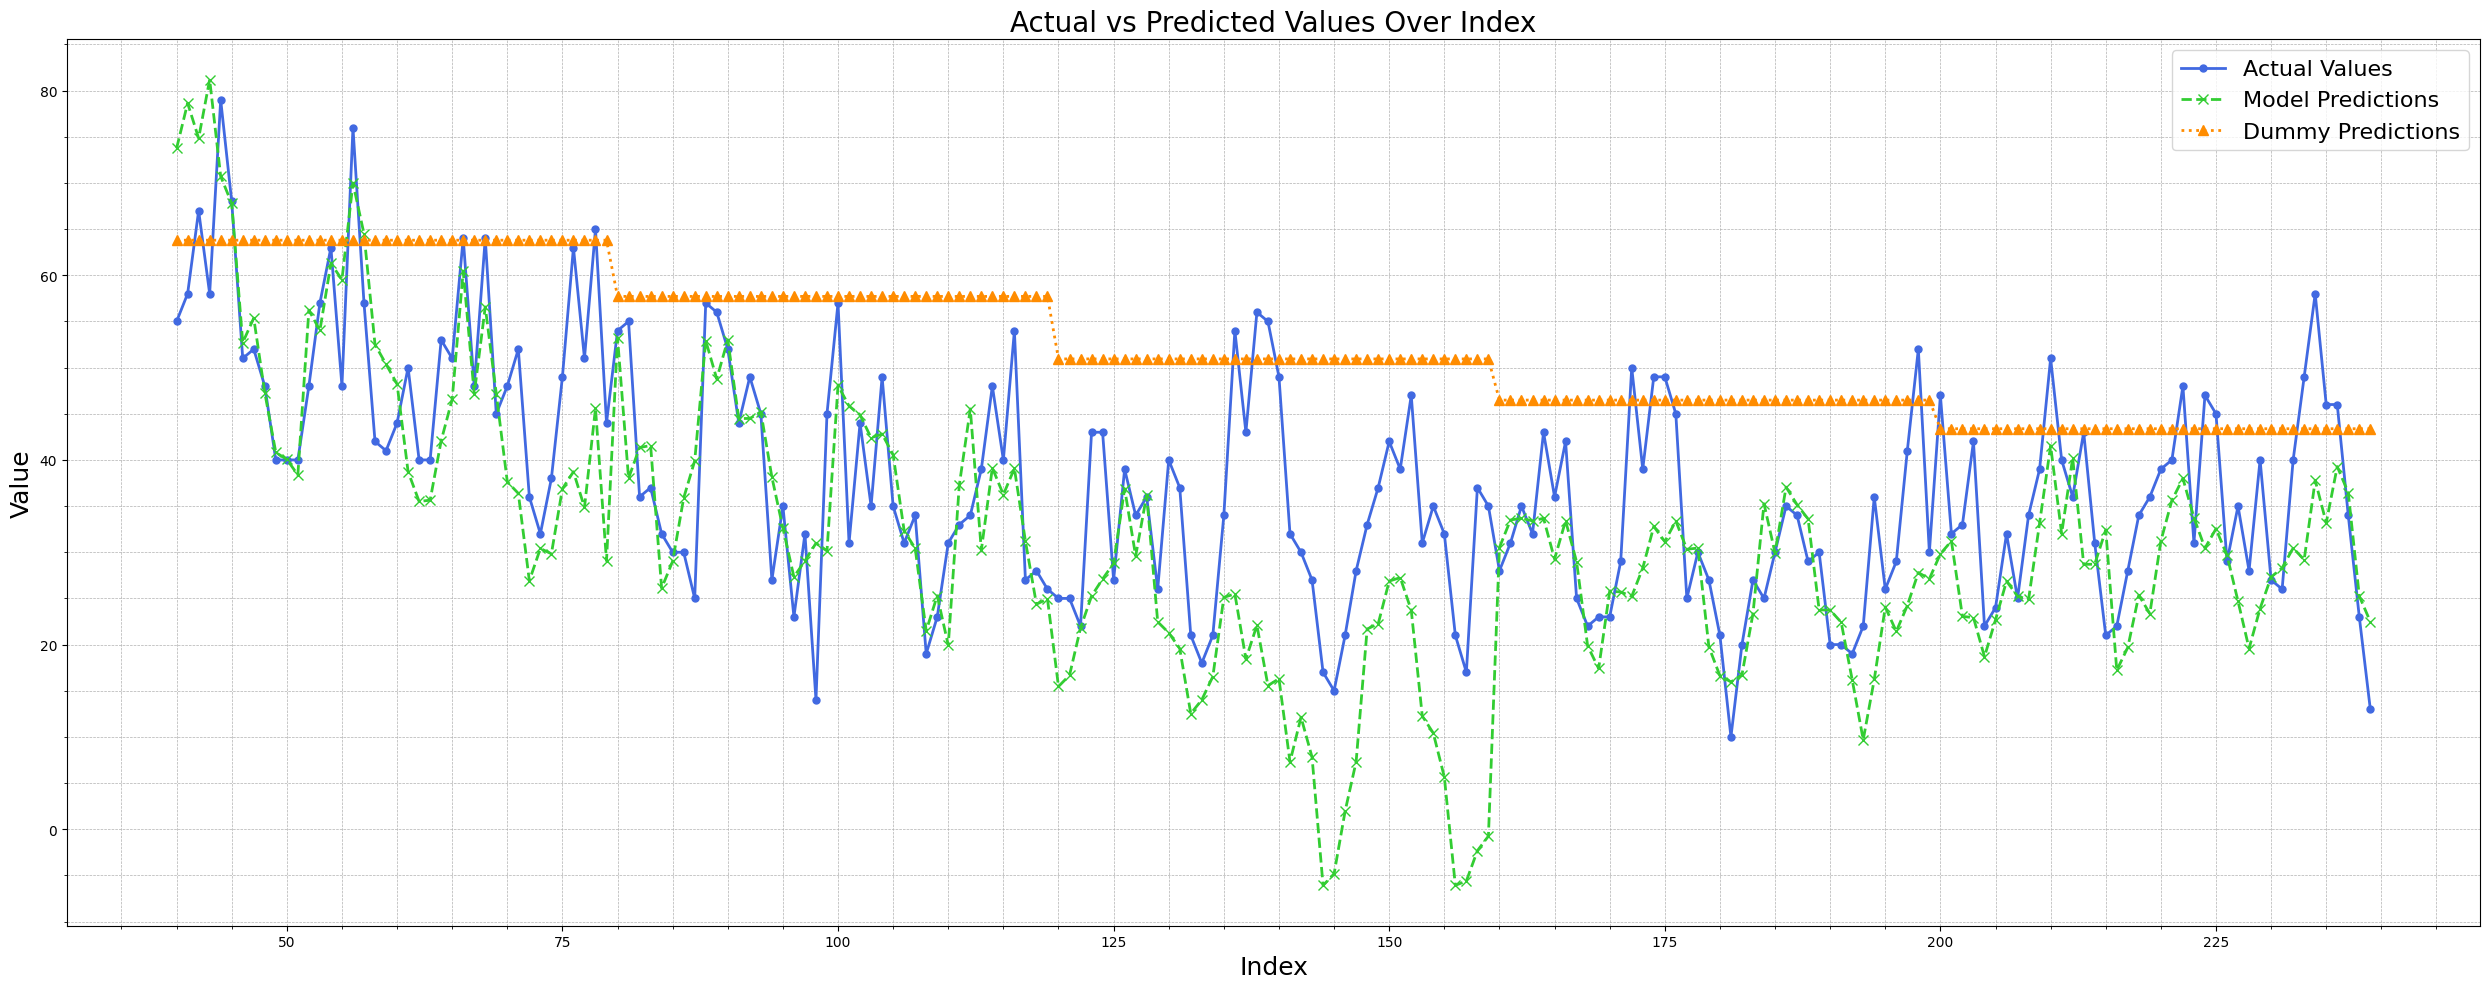

In [23]:
def calculate_model_rmse_scores(X, y, model, cv):
    """Calculates and returns RMSE scores for the actual model."""
    rmse_scores = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        rmse_scores.append(mean_squared_error(y_test, model.predict(X_test), squared=False))
    return rmse_scores

def plot_actual_vs_predicted(indices, actuals, model_predictions, dummy_predictions):
    """Plots actual vs predicted values."""
    plt.figure(figsize=(25, 10))
    plt.plot(indices, actuals, 'o-', color='royalblue', label='Actual Values', linewidth=2, markersize=5)
    plt.plot(indices, model_predictions, 'x--', color='limegreen', label='Model Predictions', linewidth=2, markersize=7)
    plt.plot(indices, dummy_predictions, '^:', color='darkorange', label='Dummy Predictions', linewidth=2, markersize=7)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.title('Actual vs Predicted Values Over Index', fontsize=20)
    plt.xlabel('Index', fontsize=18)
    plt.ylabel('Value', fontsize=18)
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.show()

# Initialize models and cross-validation strategy
tscv = TimeSeriesSplit(n_splits=5)
model = LinearRegression()
dummy_model = DummyRegressor(strategy='mean')

# Assuming 'df' is your DataFrame with the 'Value' column as the target
X, y = df.drop('Value', axis=1), df['Value']

# Calculate RMSE scores and print
model_rmse = calculate_model_rmse_scores(X, y, model, tscv)
dummy_rmse = calculate_model_rmse_scores(X, y, dummy_model, tscv)
print(f"Model RMSE scores: {model_rmse}")
print(f"Dummy Model RMSE scores: {dummy_rmse}")
print(f"Average Model RMSE: {np.mean(model_rmse)}")
print(f"Average Dummy Model RMSE: {np.mean(dummy_rmse)}")

# Collect predictions and plot
actuals, model_preds, dummy_preds, indices = [], [], [], []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    dummy_model.fit(X_train, y_train)
    model_preds.extend(model.predict(X_test))
    dummy_preds.extend(dummy_model.predict(X_test))
    actuals.extend(y_test)
    indices.extend(test_index)

plot_actual_vs_predicted(indices, actuals, model_preds, dummy_preds)